# Butterfly Factorization

Following the paper "[An algorithm for the rapid evaluation 
of special function transforms](https://doi.org/10.1016/j.acha.2009.08.005)", by Michael O’Neil, Franco Woolfe, Vladimir Rokhlin.

In [2]:
import numpy as np
import scipy.linalg as la
import scipy.linalg.interpolative as sli
import matplotlib.pyplot as plt
import scipy.special as sps
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

Set some parameters: (ignore `nlevels` for now)

In [95]:
#nlevels = 4
#nlevels = 7
nlevels = 9
n = 2**(nlevels + 2)

# Part 1: Constant-Area Ranks

## The Discrete Fourier Transform

In [96]:
def make_dft(n, power):
    omega = np.exp(2*np.pi*1j/n)

    ns = np.arange(n)
    exponents = ns.reshape(-1, 1) * ns
    
    return omega**(power*exponents)

dft = make_dft(n, power=1)
idft = make_dft(n, power=-1)

In [75]:
la.norm(np.abs(idft @ dft) - n*np.eye(n))

1.0665710446355353e-07

Verify the FFT property:

7.629497034145061e-11


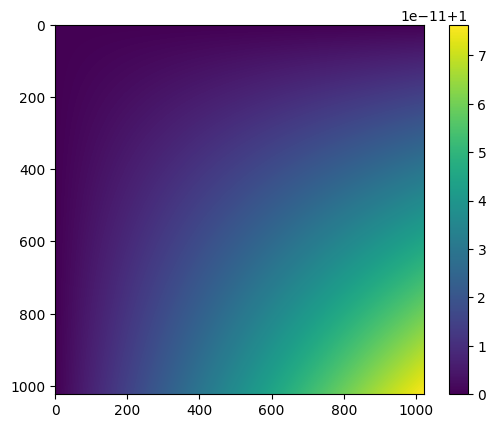

In [76]:
quotient = dft[::2, :n//2] / make_dft(n//2, power=1)
plt.imshow(quotient.real)
plt.colorbar()
print(np.max(np.abs(quotient - 1)))

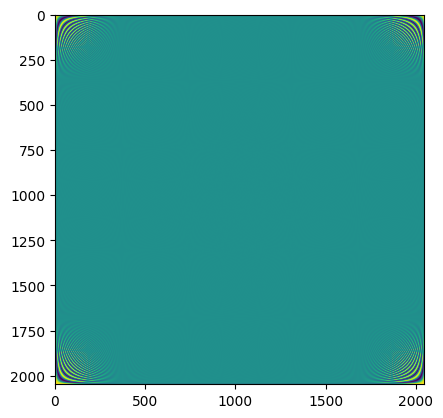

In [77]:
plt.imshow(dft.real)

Consider the the claim that the numerical rank of the kernel $e^{ixt}$ for $x\in[0,X]$ and $t\in[0,T]$ depends only on the product $XT$:

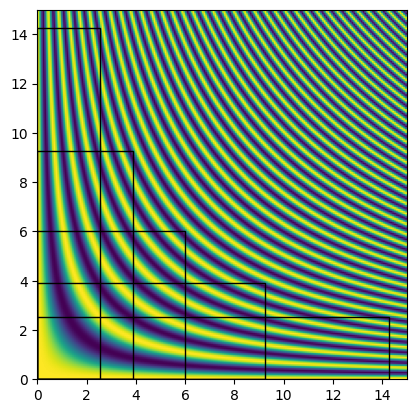

In [78]:
T = 15
X = 15
resolution = 200

x, t = np.mgrid[0:X:resolution * 1j, 0:T:resolution * 1j]

mat = np.exp(1j*x*t)
plt.imshow(mat[:, ::-1].T.real, extent=(0, X, 0, T))

scale = 6
for exp in np.linspace(-1.25, 1.25, 5):
    subX = 2**exp * scale
    subT = 2**-exp * scale
    plt.gca().add_patch(Rectangle((0, 0), subX, subT, fill=False))

# Observe: These are all the same matrix!

In [79]:
Xfacs = np.linspace(1/2, 2, 30)
Tfacs = 1/Xfacs

# Change me
scale = np.pi  
resolution = 30

for Xfac, Tfac in zip(Xfacs, Tfacs):
    x, t = np.mgrid[0:Xfac*scale:resolution * 1j, 0:Tfac*scale:resolution * 1j]
    mat = np.exp(1j*x*t)
    
    _, sigma, _ = la.svd(mat)
    print(f"{Xfac:.2f} {Tfac:.2f}\t", np.sum(sigma > 1e-7))

0.50 2.00	 11
0.55 1.81	 11
0.60 1.66	 11
0.66 1.53	 11
0.71 1.41	 11
0.76 1.32	 11
0.81 1.23	 11
0.86 1.16	 11
0.91 1.09	 11
0.97 1.04	 11
1.02 0.98	 11
1.07 0.94	 11
1.12 0.89	 11
1.17 0.85	 11
1.22 0.82	 11
1.28 0.78	 11
1.33 0.75	 11
1.38 0.72	 11
1.43 0.70	 11
1.48 0.67	 11
1.53 0.65	 11
1.59 0.63	 11
1.64 0.61	 11
1.69 0.59	 11
1.74 0.57	 11
1.79 0.56	 11
1.84 0.54	 11
1.90 0.53	 11
1.95 0.51	 11
2.00 0.50	 11


## The Legendre Vandermonde / Transform

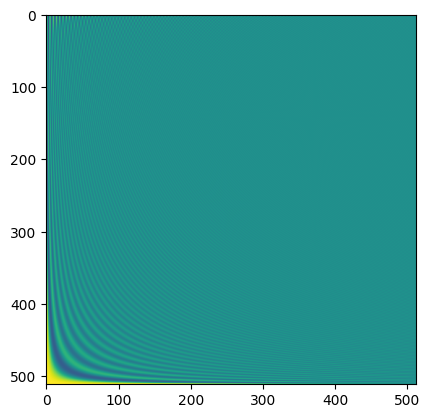

In [82]:
lege_nodes = sps.legendre(n).weights[:, 0]
lege_vdm = np.array([sps.eval_legendre(i, lege_nodes) for i in range(n)]).T
plt.imshow(lege_vdm)

## The Chebyshev Transform

In [57]:
k = n-1

i = np.arange(0, k+1)
x = np.linspace(-1, 1, 3000)

nodes = np.cos(i/k*np.pi)

i = np.arange(n, dtype=np.float64)
nodes = np.cos((2*(i+1)-1)/(2*n)*np.pi)
chebyshev_vdm = np.cos(i*np.arccos(nodes.reshape(-1, 1)))

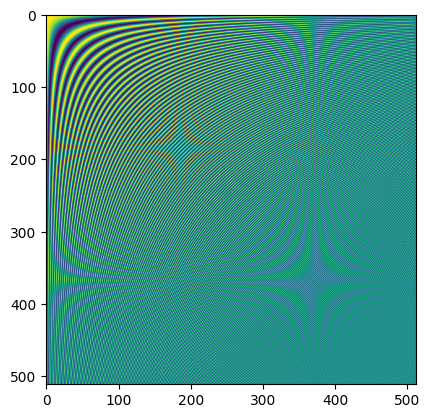

In [58]:
plt.imshow(chebyshev_vdm)

### A Random Matrix

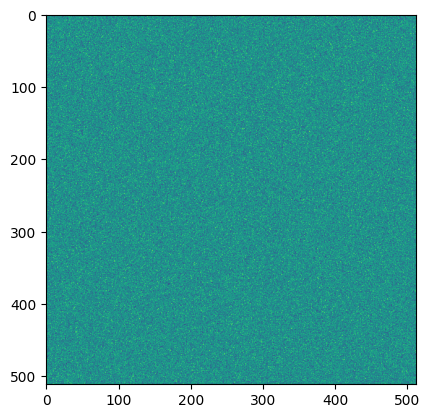

In [59]:
randmat = np.random.randn(n, n)
plt.imshow(randmat)

# Part 2: The Butterfly Factorization

## A Matrix Slicing Helper

In [97]:
class Level:
    def __init__(self, level, nlevels, n=None):
        self.level = level
        self.nlevels = nlevels
        
        if level > nlevels:
            raise ValueError("level too large")
            
        if n is None:
            n = 2**nlevels
        self.n = n
        
    @property
    def nblock_rows(self):
        return 2**self.level
        
    @property
    def block_nrows(self):
        return self.n//self.nblock_rows

    @property
    def nblock_cols(self):
        return 2**(self.nlevels-self.level)
        
    @property
    def block_ncols(self):
        return self.n//self.nblock_cols
    
    def matview(self, bi, bj, mat):
        br = self.block_nrows
        bc = self.block_ncols
        return mat[br*bi:br*(bi+1), bc*bj:bc*(bj+1)]
    
    def rowview(self, bi, vec):
        br = self.block_nrows
        return vec[br*bi:br*(bi+1)]
    
    def colview(self, bj, vec):
        bc = self.block_ncols
        return vec[bc*bj:bc*(bj+1)]

In [98]:
Level(0, nlevels, 256).matview(0, 0, dft).shape

(256, 0)

## Rank-Revealing Factorization

In [99]:
epsilon = 1e-10

In [100]:
# ID

def id_decomp(A):
    k, idx, proj = sli.interp_decomp(A, epsilon)
    sort_idx = np.argsort(idx)
    B = A[:,idx[:k]]
    P = np.hstack([np.eye(k), proj])[:,np.argsort(idx)]
    return B, P

In [101]:
# Rank-Revealing Truncated QR

def qr_decomp(A):
    q, r, p = la.qr(A, pivoting=True, mode="economic")
    diag_r = np.diag(r)
    r = r[:, np.argsort(p)]
    
    flags = np.abs(diag_r) >= epsilon
    q = q[:, flags]
    r = r[flags]
    return q, r

In [102]:
#decomp = qr_decomp
decomp = id_decomp

In [103]:
def make_low_rank_matrix(n):
    A0 = np.random.randn(n, n)
    U0, sigma0, VT0 = la.svd(A0)
    sigma = np.exp(-np.arange(n))
    return (U0 * sigma).dot(VT0)

Atest = make_low_rank_matrix(100)
Btest, Ptest = decomp(Atest)

la.norm(Atest - Btest@Ptest)/la.norm(Atest)

1.0681674657170179e-10

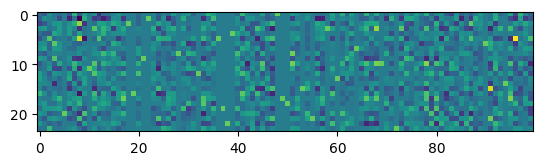

In [104]:
plt.imshow(Ptest)

## Precomputation

In [105]:
A = dft

# keys: [level][i, j]
Ps = [{} for i in range(nlevels+1)]
Bs = [{} for i in range(nlevels+1)] 

### Level 0

In [106]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        b, p = Bs[0][i, j], Ps[0][i, j] = decomp(lev.matview(i, j, A))
        if (i, j) == (0, 0):
            print(f"B: {b.shape[0]}x{b.shape[1]} P: {p.shape[0]}x{p.shape[1]}")

B: 2048x4 P: 4x4


### Levels 1, ..., L

In [107]:
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            # only process even j
            if j % 2 != 0:
                continue
                
            bblock = np.hstack((
                Bs[ilev-1][j//2, 2*k],
                Bs[ilev-1][j//2, 2*k+1],
                ))
            bblock_top = bblock[:lev.block_nrows]
            bblock_bottom = bblock[lev.block_nrows:]
            assert len(bblock_top)*2 == len(bblock)
            
            Bs[ilev][j, k], Ps[ilev][j, k] = decomp(bblock_top)
            Bs[ilev][j+1, k], Ps[ilev][j+1, k] = decomp(bblock_bottom)

            if (j, k) == (0, 0):
                tB = Bs[ilev][j, k].shape
                tP = Ps[ilev][j, k].shape
                print(
                    f"Level {ilev}: {lev.block_nrows}x{lev.block_ncols} "
                    f"Btop: {bblock_top.shape[0]}x{bblock_top.shape[1]} -> B: {tB[0]}x{tB[1]} P: {tP[0]}x{tP[1]}")

Level 1: 1024x8 Btop: 1024x8 -> B: 1024x8 P: 8x8
Level 2: 512x16 Btop: 512x16 -> B: 512x16 P: 16x16
Level 3: 256x32 Btop: 256x32 -> B: 256x17 P: 17x32
Level 4: 128x64 Btop: 128x34 -> B: 128x17 P: 17x34
Level 5: 64x128 Btop: 64x34 -> B: 64x17 P: 17x34
Level 6: 32x256 Btop: 32x34 -> B: 32x17 P: 17x34
Level 7: 16x512 Btop: 16x34 -> B: 16x16 P: 16x34
Level 8: 8x1024 Btop: 8x32 -> B: 8x8 P: 8x32
Level 9: 4x2048 Btop: 4x16 -> B: 4x4 P: 4x16


Text(0, 0.5, 'Rank')

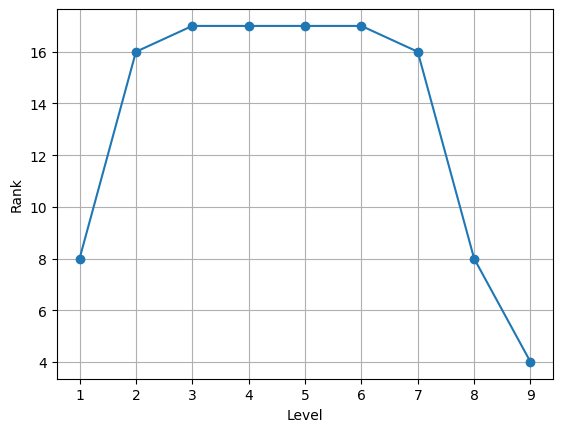

In [108]:
levels = []
ranks = []

for ilev in range(1, nlevels + 1):
    levels.append(ilev)
    ranks.append(Bs[ilev][0,0].shape[1])
    
plt.plot(levels, ranks, "o-")
plt.grid()
plt.xlabel("Level")
plt.ylabel("Rank")

Only the last-level $B$ actually needs to be retained:

In [109]:
LLB = Bs[-1]
del Bs

## Matvec

First, generate a random input:

In [110]:
x = np.random.randn(n)

### Setup

In [111]:
# keys: [ilevel][i, j]
betas = [{} for i in range(nlevels+1)]

### Level 0

In [112]:
lev = Level(0, nlevels, n)

assert lev.nblock_rows == 1
for i in range(lev.nblock_rows):
    for j in range(lev.nblock_cols):
        betas[0][i, j] = Ps[0][i, j] @ lev.colview(j, x)

### Level 1, ..., L

In [113]:
#clear
for ilev in range(1, nlevels + 1):
    lev = Level(ilev, nlevels, n)

    for j in range(lev.nblock_rows):
        for k in range(lev.nblock_cols):
            beta_glued = np.hstack((
                betas[ilev-1][j//2, 2*k],
                betas[ilev-1][j//2, 2*k+1]
                ))
            
            betas[ilev][j, k] = Ps[ilev][j, k] @ beta_glued
            if (j, k) == (0, 0):
                p = Ps[ilev][j, k]
                print(f"P: {p.shape[0]}x{p.shape[1]} * ({lev.nblock_rows}x{lev.nblock_cols} = {lev.nblock_rows*lev.nblock_cols})")

P: 8x8 * (2x256 = 512)
P: 16x16 * (4x128 = 512)
P: 17x32 * (8x64 = 512)
P: 17x34 * (16x32 = 512)
P: 17x34 * (32x16 = 512)
P: 17x34 * (64x8 = 512)
P: 16x34 * (128x4 = 512)
P: 8x32 * (256x2 = 512)
P: 4x16 * (512x1 = 512)


### Postprocess

In [114]:
Ax = np.zeros(n, dtype=np.complex128)

lev = Level(nlevels, nlevels, n)

assert lev.nblock_cols == 1
for j in range(lev.nblock_rows):
    for k in range(lev.nblock_cols):
        lev.rowview(j, Ax)[:] = LLB[j, k] @ betas[nlevels][j, k]

In [115]:
la.norm(Ax - A@x)/la.norm(A@x)

6.847661548741153e-11